# APACHE SPARK CLUSTERING

## Tugas 2 Big Data

### Requirements

1. Apache Spark 2.40
2. Python 3.7.1
3. JDK 1.8.0
4. Pixiedust 1.5.3

# Preparation

## 1. Spark Initialization

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME
import findspark
findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
# Print Spark object ID
print(spark)

## 2. Loading Data using Spark

In [4]:
df = spark.read.csv("/Users/gunstringer/Downloads/epa_hap_daily_summary.csv", header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- state_code: integer (nullable = true)
 |-- county_code: integer (nullable = true)
 |-- site_num: integer (nullable = true)
 |-- parameter_code: integer (nullable = true)
 |-- poc: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter_name: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: timestamp (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: integer (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: integer (nullable = true)
 |-- aqi: string (nullable = true)
 |-- method_code: integer (nullable = true)
 |-- method_name: string (nullable = true)
 |-- local_site_name: st

In [7]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("pollution")

In [8]:
row_count = spark.sql ("SELECT COUNT(1)FROM pollution")

In [9]:
row_count.show()

+--------+
|count(1)|
+--------+
| 8097069|
+--------+



In [10]:
df.count()

8097069

In [11]:
data = spark.sql("SELECT latitude, longitude, parameter_name, arithmetic_mean, state_name FROM pollution")

In [12]:
data.show()

+---------+-----------+--------------------+---------------+------------+
| latitude|  longitude|      parameter_name|arithmetic_mean|  state_name|
+---------+-----------+--------------------+---------------+------------+
|40.445278| -80.420833|    Arsenic PM2.5 LC|          0.003|Pennsylvania|
|32.805818| -97.356568|  Ethylene dibromide|            0.0|       Texas|
|32.057581| -92.435157|       Lead PM2.5 LC|        0.00228|   Louisiana|
| 41.60668| -87.304729|             Benzene|       0.413913|     Indiana|
| 40.53999| -121.57646|     Nickel PM2.5 LC|         1.3E-4|  California|
|42.306674| -83.148754|       Lead PM10 STP|         0.0163|    Michigan|
|34.733889|-120.008349|       Lead PM2.5 LC|            0.0|  California|
|18.425652| -66.115846|     Nickel PM2.5 LC|         0.0127| Puerto Rico|
|38.656498| -90.198646|Acrolein - Unveri...|            0.0|    Missouri|
|37.950741|-121.268523|  Chromium (TSP) STP|          0.003|  California|
|39.340556| -76.582222|cis-13-Dichloro

# Clustering Process
Tahap-tahap yang perlu dilakukan adalah sebagai berikut
## 1. Assembling Vector

Library Spark ML hanya menerima data input dalam bentuk vektor. Oleh karena itu, kita perlu menggabungkan kolom-kolom ke dalam sebuah vektor.
Misal apabila kita memiliki kolom latitude dan longitude yang ingin dijadikan sebagai sebuah input, maka kita harus menjadikannya menjadi [latitude, longitude].


In [13]:
# assembling vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol='features')

data = assembler.transform(data)
data.show()

+---------+-----------+--------------------+---------------+------------+--------------------+
| latitude|  longitude|      parameter_name|arithmetic_mean|  state_name|            features|
+---------+-----------+--------------------+---------------+------------+--------------------+
|40.445278| -80.420833|    Arsenic PM2.5 LC|          0.003|Pennsylvania|[40.445278,-80.42...|
|32.805818| -97.356568|  Ethylene dibromide|            0.0|       Texas|[32.805818,-97.35...|
|32.057581| -92.435157|       Lead PM2.5 LC|        0.00228|   Louisiana|[32.057581,-92.43...|
| 41.60668| -87.304729|             Benzene|       0.413913|     Indiana|[41.60668,-87.304...|
| 40.53999| -121.57646|     Nickel PM2.5 LC|         1.3E-4|  California|[40.53999,-121.57...|
|42.306674| -83.148754|       Lead PM10 STP|         0.0163|    Michigan|[42.306674,-83.14...|
|34.733889|-120.008349|       Lead PM2.5 LC|            0.0|  California|[34.733889,-120.0...|
|18.425652| -66.115846|     Nickel PM2.5 LC|      

## 2. Train model
Proses training dilakukan dengan memasukkan data latih ke dalam instance dengan mengeset beberapa parameter. Untuk K-Means hanya memerlukan parameter jumlah cluster (k) dan seed (randomness).


In [14]:
# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(data)

## 3. Prediksi
Proses prediksi dilakukan dengan memasukkan data uji ke dalam model yang telah dibuat.

In [23]:
# Make a prediction
predictions = model.transform(data)
predictions.show(5)

+---------+----------+------------------+---------------+------------+--------------------+----------+
| latitude| longitude|    parameter_name|arithmetic_mean|  state_name|            features|prediction|
+---------+----------+------------------+---------------+------------+--------------------+----------+
|40.445278|-80.420833|  Arsenic PM2.5 LC|          0.003|Pennsylvania|[40.445278,-80.42...|         6|
|32.805818|-97.356568|Ethylene dibromide|            0.0|       Texas|[32.805818,-97.35...|         0|
|32.057581|-92.435157|     Lead PM2.5 LC|        0.00228|   Louisiana|[32.057581,-92.43...|         0|
| 41.60668|-87.304729|           Benzene|       0.413913|     Indiana|[41.60668,-87.304...|         6|
| 40.53999|-121.57646|   Nickel PM2.5 LC|         1.3E-4|  California|[40.53999,-121.57...|         4|
+---------+----------+------------------+---------------+------------+--------------------+----------+
only showing top 5 rows




## 4. Evaluasi
Proses evaluasi dilakukan sesuai dengan algoritma yang dipakai. Untuk K-Means evaluasi yang dapat digunakan adalah Silhouette Evaluation.

In [16]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.625198998071943


In [17]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 31.04103121 -95.55614789]
[  37.71943058 -109.05450872]
[ 41.13987492 -74.40735047]
[  26.62122815 -157.23530063]
[  36.57061666 -119.6290823 ]
[  48.16690446 -124.58056784]
[ 40.84274433 -85.502848  ]
[ 32.14282485 -81.88952483]
[0. 0.]
[ 43.71027892 -94.38379329]


# Visualization

In [20]:
# Visualization using pixiedust
import pixiedust

Table service_connections created successfully


In [21]:
# Clustering berdasarkan longitude dan latitude
display(predictions)


# Clustering 2

In [77]:
# data rata rata polusi benzene pada US disetiap state 
data2 = spark.sql ("SELECT avg(latitude) as latitude, avg(longitude) as longitude, state_name, avg(arithmetic_mean) as Benzene_Mean, units_of_measure FROM pollution\
                        WHERE parameter_name = 'Benzene'\
                        Group by state_name, units_of_measure\
                        Order by Benzene_Mean")
data2.show()

+------------------+-------------------+--------------+------------------+--------------------+
|          latitude|          longitude|    state_name|      Benzene_Mean|    units_of_measure|
+------------------+-------------------+--------------+------------------+--------------------+
| 42.87756491621485|  -71.5982736232133| New Hampshire|0.5744571232134056|Parts per billion...|
|  34.5634407392697| -80.34969959833447|South Carolina|0.7905663036515054|Parts per billion...|
| 44.06909576796797| -69.63548142047676|         Maine|0.8169676743021421|Parts per billion...|
|41.514525878709804| -72.86496482602134|   Connecticut| 1.056075295483871|Parts per billion...|
| 42.36715412810498| -71.46443382947844| Massachusetts|1.1528775946907694|Parts per billion...|
| 33.50253836347307| -84.10858242591438|       Georgia| 1.205448875507971|Parts per billion...|
|17.715706875000006| -64.78593331249999|Virgin Islands|            1.2225|Parts per billion...|
|  37.5810302308474| -76.56139827457604|

In [78]:
data2.count()

51

In [79]:
#Assembling data set Benzene_Mean as features
assembler = VectorAssembler(
    inputCols=["Benzene_Mean"],
    outputCol='features')

data2 = assembler.transform(data2)

In [80]:
# Train Model
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(data2)

In [81]:
# Make a prediction
predictions2 = model.transform(data2)
predictions2.show(5)

+------------------+------------------+--------------+------------------+--------------------+--------------------+----------+
|          latitude|         longitude|    state_name|      Benzene_Mean|    units_of_measure|            features|prediction|
+------------------+------------------+--------------+------------------+--------------------+--------------------+----------+
| 42.87756491621485| -71.5982736232133| New Hampshire|0.5744571232134056|Parts per billion...|[0.5744571232134056]|         0|
|  34.5634407392697|-80.34969959833447|South Carolina|0.7905663036515054|Parts per billion...|[0.7905663036515054]|         0|
| 44.06909576796797|-69.63548142047676|         Maine|0.8169676743021421|Parts per billion...|[0.8169676743021421]|         0|
|41.514525878709804|-72.86496482602134|   Connecticut| 1.056075295483871|Parts per billion...| [1.056075295483871]|         0|
| 42.36715412810498|-71.46443382947844| Massachusetts|1.1528775946907694|Parts per billion...|[1.15287759469076

In [82]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions2)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6831184784426577


In [84]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.38192306]
[4.95521624]
[8.70879747]
[3.1189377]
[2.2497532]


In [85]:
# Visualisasi Data Clustering Tingkat polusi benzene pada setiap state (MAPS)
display(predictions2)

![cluster](img/2.png)


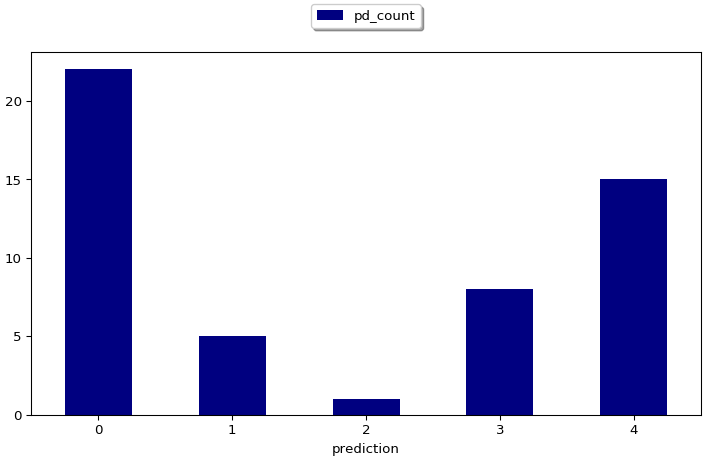

In [86]:
#jumlah aggota dari masing masing kelas
display(predictions2)

In [ ]:
![cluster](img/3.png)